In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('visadata')

In [2]:
df.duplicated().sum()

0

## Clean

In [3]:
df.drop(['case_id','_id'], axis = 1, inplace = True)

In [4]:
from datetime import date

todays_date = date.today()
current_year = todays_date.year

In [5]:
current_year

2024

In [6]:
df['company_age'] = current_year - df['yr_of_estab']

In [7]:
df.drop('yr_of_estab', inplace = True, axis = 1)

In [8]:
df['no_of_employees'] = np.absolute(df['no_of_employees'])

In [9]:
df.describe()

,no_of_employees,prevailing_wage,company_age
count,25480.000000,25480.000000,25480.000000
mean,5667.089207,74455.814592,44.590071
std,22877.917453,52815.942327,42.366929
min,11.000000,2.136700,8.000000
25%,1022.000000,34015.480000,19.000000
50%,2109.000000,70308.210000,27.000000
75%,3504.000000,107735.512500,48.000000
max,602069.000000,319210.270000,224.000000


# Basic EDA

## Numerical Features:

In [10]:
nums = [feature for feature in df.columns if df[feature].dtype != 'O']

print(f'Number of numerical features {len(nums)}')

Number of numerical features 3


## Categorical Features:

In [11]:
cats = [feature for feature in df.columns if df[feature].dtype == 'O']

print(f'Number of categorical features {len(cats)}')

Number of categorical features 8


## Discrete Features:

In [12]:
disc = [feature for feature in nums if len(df[feature].unique()) <= 25]

print(f'Number of discrete features {len(disc)}')

Number of discrete features 0


## Continuous Features:

In [13]:
cont = nums = [feature for feature in nums if feature not in disc]

print(f'Number of continuous features {len(cont)}')

Number of continuous features 3


# Modeling

## Split train / test

In [14]:
X = df.drop('case_status', axis = 1)
y = df['case_status']

In [15]:
y = np.where(y=='Denied', 1, 0)
y

array([1, 0, 1, ..., 0, 0, 0])

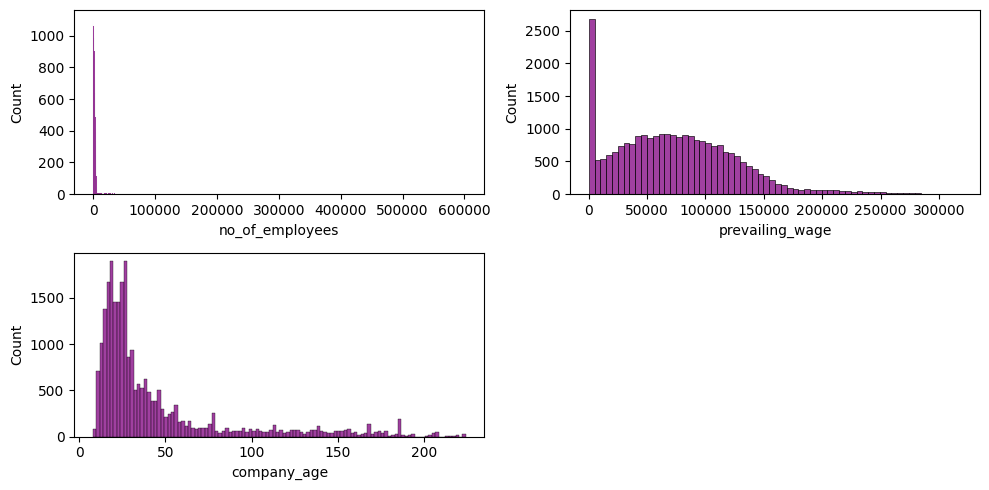

In [16]:
plt.figure(figsize = (10,5))
for i, col in enumerate(['no_of_employees','prevailing_wage','company_age']):
    plt.subplot(2,2, i + 1)
    sns.histplot(x = X[col], color = 'purple')
    plt.xlabel = (col)
    plt.tight_layout()

In [17]:
X[cont].skew(axis = 0,skipna=True)

no_of_employees    12.265273
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

In [18]:
X.shape

(25480, 10)

## Power transformation

Remember decision tree does not need to be scaled, keep a copy of the data that is not scaled (distribution free).

In [19]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

trans_feat = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(X[trans_feat])

In [20]:
X_copy = pd.DataFrame(X_copy, columns = trans_feat)

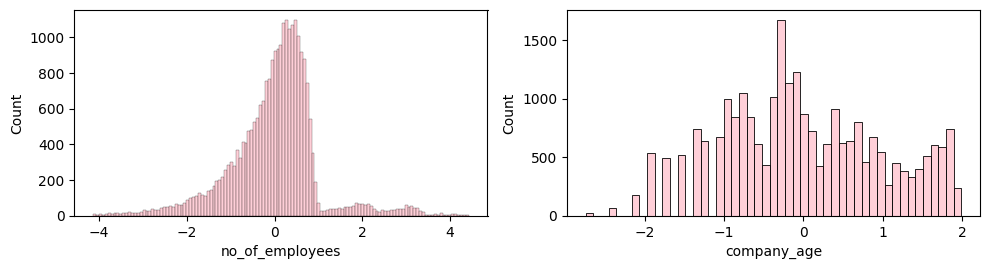

In [21]:
plt.figure(figsize = (10,5))
for i, col in enumerate(['no_of_employees','company_age']):
    plt.subplot(2,2, i + 1)
    sns.histplot(x = X_copy[col], color = 'pink')
    plt.xlabel = (col)
    plt.tight_layout()

In [22]:
X_copy.skew(axis = 0, skipna = True)

company_age        0.103264
no_of_employees   -0.014466
dtype: float64

In [23]:
ordinal_columns = ['has_job_experience', 'requires_job_training', 'full_time_position', 'education_of_employee']
nominal_columns = ['continent', 'unit_of_wage', 'region_of_employment']
transform_columns = ['no_of_employees', 'company_age', 'prevailing_wage']

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


numeric_transformer = StandardScaler()
nominal_transformer = OneHotEncoder()
ordinal_transformer = OrdinalEncoder()

transform_pipe = Pipeline(steps = [
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", nominal_transformer, nominal_columns),
        ("Ordinal_Encoder", ordinal_transformer, ordinal_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, nums)
    ]
)

In [24]:
X = preprocessor.fit_transform(X)

In [25]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666476,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228363,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498259,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.1987147 ,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387693,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805781,
        -0.06776315,  0.45814768]])

In [26]:
df['case_status'].value_counts()

case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

In [27]:
from imblearn.combine import SMOTEENN, SMOTETomek

smt = SMOTEENN(random_state = 42, sampling_strategy = 'minority')

X_res, y_res = smt.fit_resample(X,y)

In [28]:
y_res

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test  = train_test_split(X_res, y_res, test_size = 0.2, random_state=42)
X_train.shape, X_test.shape

((13723, 25), (3431, 25))

In [30]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier

models = {
    "Random Forest" : RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "Support Vector Classifier": SVC(),
    "AdaBoost": AdaBoostClassifier()
}

In [31]:
def evaluate_models(X,y, models):
    '''

    This functions takes in parameters X, y, and the dictionary
    of models splits the data
    iterates through the dictionary of models
    collects the model metrics
    returns a dataframe of the model and their metrics
    '''

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)
    models_list = []
    accuracy_list = []
    auc = []

    for i in range(len(list(models))):
        model = list(models.values())
        model.fit(X_train, y_train)

        # make predictions
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)

         # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')

    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)

    return report
    